# Exercise 2: Finite State Transducers
Dartmouth College, LING48, Spring 2023<br>
Kevin King (kevin.m.king.24@dartmouth.edu)<br>

This program uses the `openfst` and `graphviz` packages:<br>
http://www.openfst.org/twiki/bin/view/FST/PythonExtension<br>
https://graphviz.readthedocs.io/en/stable/manual.html


In this program, you will see a transductor that reads different conjugations of the verbs ali ("to cook"), tsak ("to pop/puncture"), and bi ("to dig"). 

This program has several parts: 

(1) We have the `morphSymbols` and `translateSymbols`, which are the lists of all of the elements we use in the FST morphological decomposition and translation graphs, respectively. 

(2) We have a list of compiler instructions. This is the list of all the transitions and final states in the FST.

(3) We have the `spellout` function. This function has the string as its input, and then goes character by character, calculating the path through the FST and its corresponding transformations. In addition, `linear_fst`, `apply_fst`, and `accepted` help in carrying out the FST processing.

(4) Finally, we have a function that prints the FST into a PDF so you can see the transitions graphically, and then some code that allows you to save the files. 

Step 1: Install the necessary packages.

These are available for Linux computers on Anaconda, but they are not available for Windows Anaconda and they are difficult to install in MacOS Anaconda (https://anaconda.org/conda-forge/openfst).

In [2]:
# This will install Python 3.7 in the virtual computer.
# This is needed to run the FST packages
# This should take about 40 seconds

%env PYTHONPATH=
!echo $PYTHONPATH

! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.12.0-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.12.0-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.12.0-Linux-x86_64.sh -b -f -p /usr/local/

import sys
sys.path.append("/usr/local/lib/python3.7/site-packages")
!conda config --add channels bioconda
!conda config --add channels conda-forge

env: PYTHONPATH=

--2023-04-16 17:59:07--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.12.0-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104996770 (100M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.12.0-Linux-x86_64.sh’

Miniconda3-py37_4.1 100%[===================>] 100.13M   182MB/s    in 0.6s    

2023-04-16 17:59:08 (182 MB/s) - ‘Miniconda3-py37_4.12.0-Linux-x86_64.sh’ saved [104996770/104996770]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2022.3.29=h06a4308_1
    - certifi==2021.10.8=py37h06a4308_2
    - cffi==

In [3]:
!pip install openfst-python
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.0 MB 4.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 2.5 MB/s 


Step 2: Load packages

In [4]:
import openfst_python as fst
from graphviz import render
import graphviz
import cv2
from PIL import Image
from google.colab import files

<frozen importlib._bootstrap>:228: RuntimeWarning: compiletime version 3.7 of module 'pywrapfst' does not match runtime version 3.9


Step 3: The following four functions (linear_fst, apply_fst, accepted, spellout) carry out the FST processing. You do NOT need to modify them.

In [5]:
def linear_fst(elements, automata_op, keep_isymbols=True, **kwargs):
    """Produce a linear automata."""
    compiler = fst.Compiler(isymbols=automata_op.input_symbols().copy(), 
                            acceptor=keep_isymbols,
                            keep_isymbols=keep_isymbols, 
                            **kwargs)

    for i, el in enumerate(elements):
        print("{} {} {}".format(i, i+1, el),file=compiler)
    print(str(i+1),file=compiler)

    return compiler.compile()

def apply_fst(elements, automata_op, is_project=True, **kwargs):
    """Compose a linear automata generated from `elements` with `automata_op`.

    Args:
        elements (list): ordered list of edge symbols for a linear automata.
        automata_op (Fst): automata that will be applied.
        is_project (bool, optional): whether to keep only the output labels.
        kwargs:
            Additional arguments to the compiler of the linear automata .
    """
    linear_automata = linear_fst(elements, automata_op, **kwargs)
    out = fst.compose(linear_automata, automata_op)
    if is_project:
        out.project(project_output=True)
    return out

def accepted(output_apply):
    """Given the output of `apply_fst` for acceptor, return True is sting was accepted."""
    return output_apply.num_states() != 0

def spellout(inputString, inSymbols, inFST):
	output=""
	currentFST = apply_fst(list(inputString), inFST)
	for state in currentFST.states():
		for arc in currentFST.arcs(state):
			if (inSymbols.find(arc.olabel) != "<eps>"):
				output += inSymbols.find(arc.olabel)
	return output

Step 4: List of symbols

You need to modify the list below to match the symbols you need. My advice would be:<br>
(1) Draw the lattice on a piece of paper,<br>
(2) Make a list of the transitions, and<br>
(3) As you go through the transitions, include your symbolss in the symbol list.

Notice that the first symbol is the "epsilon", for when you expect empty strings.

In [6]:
morphSymbols = fst.SymbolTable()
morphSymbols.add_symbol("<eps>", 0)
morphSymbols.add_symbol("a", 1)
morphSymbols.add_symbol("l", 2)
morphSymbols.add_symbol("e", 3)
morphSymbols.add_symbol("n-", 4)
morphSymbols.add_symbol("H", 5)
morphSymbols.add_symbol("i", 6)
morphSymbols.add_symbol("-i", 7)
morphSymbols.add_symbol("'", 8)
morphSymbols.add_symbol("r", 9)
morphSymbols.add_symbol("n", 10)
morphSymbols.add_symbol("u", 11)
morphSymbols.add_symbol("x", 12)
morphSymbols.add_symbol("k", 13)
morphSymbols.add_symbol("o", 14)
morphSymbols.add_symbol("-o", 15)
morphSymbols.add_symbol("q", 16)
morphSymbols.add_symbol("F", 17)
morphSymbols.add_symbol("-a", 18)
morphSymbols.add_symbol("b", 19)
morphSymbols.add_symbol("-e", 20)
morphSymbols.add_symbol("t", 21)
morphSymbols.add_symbol("s", 22)

22

In [7]:
translateSymbols = fst.SymbolTable()
translateSymbols.add_symbol("<eps>", 0)
translateSymbols.add_symbol("a", 1)
translateSymbols.add_symbol("l", 2)
translateSymbols.add_symbol("e", 3)
translateSymbols.add_symbol("H", 4)
translateSymbols.add_symbol("i", 5)
translateSymbols.add_symbol("'", 6)
translateSymbols.add_symbol("r", 7)
translateSymbols.add_symbol("n", 8)
translateSymbols.add_symbol("u", 9)
translateSymbols.add_symbol("x", 10)
translateSymbols.add_symbol("k", 11)
translateSymbols.add_symbol("o", 12)
translateSymbols.add_symbol("q", 13)
translateSymbols.add_symbol("F", 14)
translateSymbols.add_symbol("cook", 15)
translateSymbols.add_symbol("-", 16)
translateSymbols.add_symbol("IPFV", 17)
translateSymbols.add_symbol("MID", 18)
translateSymbols.add_symbol("-THEME.", 19)
translateSymbols.add_symbol("PFV.IMPROSP", 20)
translateSymbols.add_symbol("INF", 21)
translateSymbols.add_symbol("IMP", 22)
translateSymbols.add_symbol("DESIDERATIVE", 23)
translateSymbols.add_symbol(".IPFV", 24)
translateSymbols.add_symbol("b", 25)
translateSymbols.add_symbol("dig", 26)
translateSymbols.add_symbol("t", 27)
translateSymbols.add_symbol("s", 28)
translateSymbols.add_symbol("pop", 29)
translateSymbols.add_symbol("-THEME.PFV.IMPROSP", 30)

30

Step 5: Build the transitions of the FSTs. You need to modify the list below. This is where you would put the transitions and the end states of your FST.

In [8]:
compiler = fst.Compiler(isymbols=morphSymbols, osymbols=morphSymbols, keep_isymbols=True, keep_osymbols=True)

# You do *not* need to comment every line. I put the comments below to
# make the program clearer, but you do not need to comment in such detail.

print("0 1 a a",file=compiler)           
print("1 2 l l",file=compiler)  # verb root al
print("2 3 e -e",file=compiler) 
print("2 4 i -i",file=compiler) 
print("3 5 H H",file=compiler)  # al-eH
print("4 5 ' '",file=compiler)  # al-i'
print("5",file=compiler) 
print("4 6 H H",file=compiler) 
print("6 7 r r",file=compiler)  # al-iHr
print("7",file=compiler) 
print("6 8 n n-",file=compiler) 
print("8 9 e e",file=compiler) 
print("9 10 x x",file=compiler) # al-iHnex
print("10",file=compiler) 
print("8 11 u u",file=compiler) 
print("11 12 x x",file=compiler)
print("2 13 o -o",file=compiler)
print("13 14 q q",file=compiler) 
print("14 15 F F",file=compiler) 
print("15 16 k k",file=compiler)  # al-oqFk, tsak-oqFk, bi-oqFk
print("12 16 k k",file=compiler)  # al-iHnuxk
print("16",file=compiler) 
print("15 17 <eps> <eps>",file=compiler)  #al-oqF
print("17",file=compiler) 
print("2 18 a -a",file=compiler) 
print("18 19 ' '",file=compiler) 
print("19 20 k k",file=compiler) 
print("20 21 u u",file=compiler) 
print("21 22 x x",file=compiler)  # al-a'kux
print("22",file=compiler) 
print("0 23 t t",file=compiler) 
print("23 24 s s",file=compiler) 
print("24 25 a a",file=compiler) 
print("25 2 k k",file=compiler) # verb root tsak
# separate states for bi- verb per the announcement from 4/15
print("0 26 b b",file=compiler) 
print("26 27 i <eps>",file=compiler) # verb root bi
print("27 28 ' -i",file=compiler)
print("28 29 <eps> '",file=compiler) 
print("29",file=compiler) 
print("27 30 <eps> i",file=compiler) 
print("30 13 o -o",file=compiler) 

morphFST = compiler.compile()

In [14]:
compiler = fst.Compiler(isymbols=translateSymbols, osymbols=translateSymbols, keep_isymbols=True, keep_osymbols=True)

# You do *not* need to comment every line. I put the comments below to
# make the program clearer, but you do not need to comment in such detail.

print("0 1 a <eps>",file=compiler)           
print("1 2 l cook",file=compiler) # verb cook
print("2 3 e -",file=compiler)  
print("2 4 i -THEME.",file=compiler)  
print("3 5 H IPFV",file=compiler) # cook-IPFV
print("4 5 ' PFV.IMPROSP",file=compiler)  # cook-THEME.PFV.IMPROSP
print("5",file=compiler) 
print("4 6 H MID",file=compiler) 
print("6 7 r .IPFV",file=compiler)  # cook-THEME.MID.IPFV
print("7",file=compiler) 
print("6 8 n -",file=compiler) 
print("8 9 e <eps>",file=compiler) 
print("9 10 x PFV.IMPROSP",file=compiler) # cook-THEME.MID-PFV.IMPROSP
print("10",file=compiler) 
print("8 11 u <eps>",file=compiler) 
print("11 12 x <eps>",file=compiler) 
print("2 13 o -",file=compiler)
print("13 14 q <eps>",file=compiler) 
print("14 15 F <eps>",file=compiler) 
print("15 16 k INF",file=compiler)  # cook-INF, tsak-INF bi-INF
print("12 16 k INF",file=compiler) # cook-THEME.MID-INF
print("16",file=compiler) 
print("15 17 <eps> IMP",file=compiler)  # cook-IMP
print("17",file=compiler) 
print("2 18 a -",file=compiler) 
print("18 19 ' <eps>",file=compiler) 
print("19 20 k <eps>",file=compiler) 
print("20 21 u <eps>",file=compiler) 
print("21 22 x DESIDERATIVE",file=compiler) # cook-DESIDERATIVE
print("22",file=compiler) 
print("0 23 t <eps>",file=compiler) 
print("23 24 s <eps>",file=compiler) 
print("24 25 a <eps>",file=compiler) 
print("25 2 k pop",file=compiler) # verb pop
# separate states for bi- verb per the announcement from 4/15
print("0 26 b <eps>",file=compiler) 
print("26 2 i dig",file=compiler) # verb dig
print("2 27 ' -THEME.PFV.IMPROSP",file=compiler) 
print("27",file=compiler) 


translateFST = compiler.compile()

Step 6: The following code is used to test the outputs of the FSTs based on the given inputs 

In [15]:
# word = "aleH"
# splitWord = spellout(word, morphSymbols, morphFST)
# wordTranslation = spellout(word, translateSymbols, translateFST)
# print(word + "\n" + splitWord + "\n" + wordTranslation + "\n")

# word = "ali'"
# splitWord = spellout(word, morphSymbols, morphFST)
# wordTranslation = spellout(word, translateSymbols, translateFST)
# print(word + "\n" + splitWord + "\n" + wordTranslation + "\n")

# word = "aloqFk"
# splitWord = spellout(word, morphSymbols, morphFST)
# wordTranslation = spellout(word, translateSymbols, translateFST)
# print(word + "\n" + splitWord + "\n" + wordTranslation + "\n")

# word = "aloqF"
# splitWord = spellout(word, morphSymbols, morphFST)
# wordTranslation = spellout(word, translateSymbols, translateFST)
# print(word + "\n" + splitWord + "\n" + wordTranslation + "\n")

# word = "ala'kux"
# splitWord = spellout(word, morphSymbols, morphFST)
# wordTranslation = spellout(word, translateSymbols, translateFST)
# print(word + "\n" + splitWord + "\n" + wordTranslation + "\n")

# word = "aliHr"
# splitWord = spellout(word, morphSymbols, morphFST)
# wordTranslation = spellout(word, translateSymbols, translateFST)
# print(word + "\n" + splitWord + "\n" + wordTranslation + "\n")

# word = "aliHnex"
# splitWord = spellout(word, morphSymbols, morphFST)
# wordTranslation = spellout(word, translateSymbols, translateFST)
# print(word + "\n" + splitWord + "\n" + wordTranslation + "\n")

# word = "aliHnuxk"
# splitWord = spellout(word, morphSymbols, morphFST)
# wordTranslation = spellout(word, translateSymbols, translateFST)
# print(word + "\n" + splitWord + "\n" + wordTranslation + "\n")

# Testing Script (given)
print("First you'll see the expected output, and then the output of the student\n")

print("01. Input:       aleH (\"I cook\")\n    Morphs:      al-eH / " + spellout("aleH", morphSymbols, morphFST) + "\n    Translation: cook-IPFV / " + spellout("aleH", translateSymbols, translateFST) + "\n")
print("02. Input:       ali' (\"I cooked\")\n    Morphs:      al-i' / " + spellout("ali'", morphSymbols, morphFST) + "\n    Translation: cook-THEME.PFV.IMPROSP / " + spellout("ali'", translateSymbols, translateFST) + "\n")
print("03. Input:       aloqFk (\"to cook\")\n    Morphs:      al-oqFk / " + spellout("aloqFk", morphSymbols, morphFST) + "\n    Translation: cook-INF / " + spellout("aloqFk", translateSymbols, translateFST) + "\n")
print("04. Input:       aloqF (\"Cook!\")\n    Morphs:      al-oqF / " + spellout("aloqF", morphSymbols, morphFST) + "\n    Translation: cook-IMP / " + spellout("aloqF", translateSymbols, translateFST) + "\n")
print("05. Input:       ala'kux (\"I want to cook\")\n    Morphs:      al-a'kux / " + spellout("ala'kux", morphSymbols, morphFST) + "\n    Translation: cook-DESIDERATIVE / " + spellout("ala'kux", translateSymbols, translateFST) + "\n")
print("15. Input:       aliHr (\"It is being cooked\")\n    Morphs:      al-iHr / " + spellout("aliHr", morphSymbols, morphFST) + "\n    Translation: cook-THEME.MID.IPFV / " + spellout("aliHr", translateSymbols, translateFST) + "\n")
print("16. Input:       aliHnex (\"It became cooked\")\n    Morphs:      al-iHn-ex / " + spellout("aliHnex", morphSymbols, morphFST) + "\n    Translation: cook-THEME.MID-PFV.IMPROSP / " + spellout("aliHnex", translateSymbols, translateFST) + "\n")
print("17. Input:       aliHnuxk (\"to be cooked\")\n    Morphs:      al-iHn-uxk / " + spellout("aliHnuxk", morphSymbols, morphFST) + "\n    Translation: cook-THEME.MID-INF / " + spellout("aliHnuxk", translateSymbols, translateFST) + "\n")

print("03. Input:       tsakoqFk (\"to pop (a bubble), to puncture an object\")\n    Morphs:      tsak-oqFk / " + spellout("tsakoqFk", morphSymbols, morphFST) + "\n    Translation: pop-INF / " + spellout("tsakoqFk", translateSymbols, translateFST) + "\n")
print("03. Input:       bioqFk (\"to dig, to make a hole in the ground\")\n    Morphs:      bi-oqFk / " + spellout("bioqFk", morphSymbols, morphFST) + "\n    Translation: dig-INF / " + spellout("bioqFk", translateSymbols, translateFST) + "\n")

print("02. Input:       bi' (\"has dug\")\n    Morphs:      bi' / " + spellout("bi'", morphSymbols, morphFST) + "\n    Translation: dig-THEME.PFV.IMPROSP / " + spellout("bi'", translateSymbols, translateFST) + "\n")
print("02. Input:       tsaki' (\"has popped\")\n    Morphs:      tsaki' / " + spellout("tsaki'", morphSymbols, morphFST) + "\n    Translation: pop-THEME.PFV.IMPROSP / " + spellout("tsaki'", translateSymbols, translateFST) + "\n")

First you'll see the expected output, and then the output of the student

01. Input:       aleH ("I cook")
    Morphs:      al-eH / al-eH
    Translation: cook-IPFV / cook-IPFV

02. Input:       ali' ("I cooked")
    Morphs:      al-i' / al-i'
    Translation: cook-THEME.PFV.IMPROSP / cook-THEME.PFV.IMPROSP

03. Input:       aloqFk ("to cook")
    Morphs:      al-oqFk / al-oqFk
    Translation: cook-INF / cook-INF

04. Input:       aloqF ("Cook!")
    Morphs:      al-oqF / al-oqF
    Translation: cook-IMP / cook-IMP

05. Input:       ala'kux ("I want to cook")
    Morphs:      al-a'kux / al-a'kux
    Translation: cook-DESIDERATIVE / cook-DESIDERATIVE

15. Input:       aliHr ("It is being cooked")
    Morphs:      al-iHr / al-iHr
    Translation: cook-THEME.MID.IPFV / cook-THEME.MID.IPFV

16. Input:       aliHnex ("It became cooked")
    Morphs:      al-iHn-ex / al-iHn-ex
    Translation: cook-THEME.MID-PFV.IMPROSP / cook-THEME.MID-PFV.IMPROSP

17. Input:       aliHnuxk ("to be cooked")

Step 7: Draw the FST transitions for the translation graph

In [16]:
def showImage(filename):
  render('dot','png',filename)    # Create PNG file (you can find it in the file structure of the virtual machine)
  img_color = cv2.rotate(cv2.imread(filename+".png",1), cv2.ROTATE_90_CLOCKWISE)  # Rotate PNG file
  cv2.imwrite(filename+".png", img_color)    # Write rotated PNG file
  im = Image.open(filename+".png")           # Open rotated file with Python Image Library (PIL)
  im.show()                                  # Display file

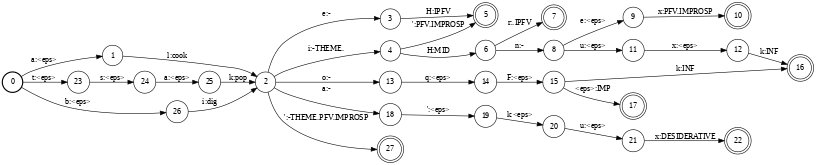

In [17]:
translateFST.draw("translate.gv")
showImage("translate.gv")

Draw the FST transitions for the morphological decomposition graph

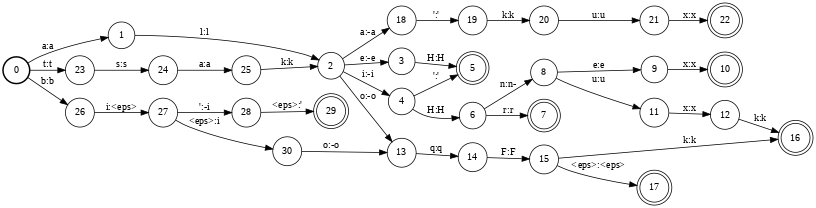

In [18]:
morphFST.draw("morph.gv")
showImage("morph.gv")

Step 8: Save the graph into a PDF file.

(This works for Google Chrome. Read here:
https://stackoverflow.com/questions/48774285/how-to-download-file-created-in-colaboratory-workspace )

In [19]:
render('dot','pdf','translate.gv')
files.download('translate.gv.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
render('dot','pdf','morph.gv')
files.download('morph.gv.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>